In [3]:
import torch
import torch.nn as nn

input = torch.randn(32, 1, 5, 5)
# flatten to 1D
m = nn.Flatten(start_dim=0, end_dim=-1)
output = m(input)
print(output.size(), input.size())


torch.Size([800]) torch.Size([32, 1, 5, 5])


In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()


for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

ModuleNotFoundError: No module named 'torch_geometric'

In [ ]:
# Evaluate the model
model.eval()

_, pred = model(data).max(dim=1)
correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / int(data.test_mask.sum())
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.7950


In [ ]:
# get the shape of data
print(data.x.size())
_, pred = model(data).max(dim=1)

torch.Size([2708, 1433])


In [ ]:
from torch import nn

log_softmax = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()
# input to NLLLoss is of size N x C = 3 x 5
input = torch.randn(3, 5, requires_grad=True)
# each element in target must have 0 <= value < C
target = torch.tensor([1, 0, 4])
print(log_softmax(input).shape, target.shape)
loss = loss_fn(log_softmax(input), target)
loss.backward()

torch.Size([3, 5]) torch.Size([3])


In [1]:
import torch
import torch.nn.functional as F
import torchvision as tv
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

from graph import GCN
from utils import image_to_adj
from tqdm import tqdm


# set random seed
torch.manual_seed(0)
torch.cuda.manual_seed(0)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the MNIST dataset
image_size = 8
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)), transforms.Resize(image_size, antialias=True)])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

adj = image_to_adj(np.zeros((image_size, image_size)))
# adj is A + I
adj = adj + torch.eye(adj.size(0))

model = GCN(1, 16, 10, 0.5, image_size)

if torch.cuda.is_available():
    model = model.cuda()
    adj = adj.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = F.cross_entropy

n_epochs = 20
model.train()

for epoch in range(n_epochs):
    for i, (image_batch, label_batch) in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        image_batch = image_batch.float().squeeze().view(train_loader.batch_size, image_size * image_size, image_batch.size(1))
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)
        
        output = model(image_batch, adj)
        # print(output[0], label_batch[0])
        loss = criterion(output.squeeze(), label_batch)
        loss.backward()
        optimizer.step()
        # break

    print(f'Epoch {epoch}, loss: {loss}')
print('Done!')

print('Test:')
model.eval()

test_data = tv.datasets.MNIST(root='./data', train=False, download=True)
test_labels = test_data.targets.to(device)
test_data = tv.transforms.Resize(8, antialias=True)(test_data.data).to(device)


correct = 0
for i, (image, label) in enumerate(test_loader):
    image = image.float().squeeze().view(test_loader.batch_size, image_size * image_size, image.size(1))
    label = label.to(device)
    image = image.to(device)
    output = model(image, adj).squeeze()
    correct += (output.argmax(dim=1) == label).sum().item()

print(f'Accuracy: {correct / len(test_data)}')

0it [00:00, ?it/s]


TypeError: cannot assign 'torch.cuda.FloatTensor' as parameter 'correlation' (torch.nn.Parameter or None expected)

In [ ]:
import torch
import torch.nn.functional as F
import torchvision as tv
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, default_collate
import matplotlib.pyplot as plt

from gat import GAT
from utils import image_to_adj
from tqdm import tqdm


# set random seed
torch.manual_seed(0)
torch.cuda.manual_seed(0)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the MNIST dataset
image_size = 16
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)), transforms.Resize(image_size, antialias=True)])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

adj = image_to_adj(train_dataset[0][0].squeeze())
# adj is A + I
# adj = adj + torch.eye(adj.size(0))

model = GAT(n_feat=1, n_class=10, n_layer=2, agg_hidden=32, fc_hidden=64, device=device)

if torch.cuda.is_available():
    model = model.cuda()
    adj = adj.cuda()

optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
criterion = F.cross_entropy

n_epochs = 30
model.train()

for epoch in range(n_epochs):
    for i, (image, label_batch) in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        image = image.float().squeeze().view(image.size(0), image_size * image_size, image.size(1))
        image = image.to(device)
        label_batch = label_batch.to(device)
        
        output = model(image, adj)
        # print(output[0], label_batch[0])
        loss = criterion(output.squeeze(), label_batch)
        loss.backward()
        optimizer.step()
        # break

    print(f'Epoch {epoch}, loss: {loss}')
print('Done!')

print('Test:')
model.eval()

test_data = tv.datasets.MNIST(root='./data', train=False, download=True)
test_labels = test_data.targets.to(device)
test_data = tv.transforms.Resize(8, antialias=True)(test_data.data).to(device)


correct = 0
for i, (image, label) in enumerate(test_loader):
    image = image.float().squeeze().view(image.size(0), image_size * image_size, image.size(1))
    label = label.to(device)
    image = image.to(device)
    output = model(image, adj).squeeze()
    correct += (output.argmax(dim=1) == label).sum().item()

print(f'Accuracy: {correct / len(test_data)}')

1875it [01:12, 25.82it/s]


Epoch 0, loss: 2.2878103256225586


1875it [01:10, 26.45it/s]


Epoch 1, loss: 2.267825126647949


1875it [01:11, 26.39it/s]


Epoch 2, loss: 2.26930570602417


1875it [01:11, 26.07it/s]


Epoch 3, loss: 2.2903623580932617


1875it [01:18, 24.00it/s]


Epoch 4, loss: 2.2627410888671875


1875it [01:18, 23.78it/s]


Epoch 5, loss: 2.2820699214935303


1875it [01:19, 23.69it/s]


Epoch 6, loss: 2.259732484817505


1875it [01:18, 23.80it/s]


Epoch 7, loss: 2.2606565952301025


1875it [01:19, 23.70it/s]


Epoch 8, loss: 2.247312068939209


1875it [01:16, 24.64it/s]


Epoch 9, loss: 2.249415397644043


1875it [01:16, 24.48it/s]


Epoch 10, loss: 2.2699949741363525


1875it [01:14, 25.02it/s]


Epoch 11, loss: 2.251877784729004


1875it [01:17, 24.12it/s]


Epoch 12, loss: 2.258760929107666


1875it [01:19, 23.67it/s]


Epoch 13, loss: 2.2558648586273193


1875it [01:19, 23.67it/s]


Epoch 14, loss: 2.2518107891082764


1875it [01:19, 23.63it/s]


Epoch 15, loss: 2.2629952430725098


1875it [01:18, 23.94it/s]


Epoch 16, loss: 2.2483417987823486


1875it [01:20, 23.20it/s]


Epoch 17, loss: 2.265115261077881


1875it [01:21, 23.10it/s]


Epoch 18, loss: 2.2534408569335938


1875it [01:18, 23.79it/s]


Epoch 19, loss: 2.2535367012023926


1875it [01:18, 23.85it/s]


Epoch 20, loss: 2.2596137523651123


1875it [01:17, 24.06it/s]


Epoch 21, loss: 2.240478038787842


1875it [01:19, 23.72it/s]


Epoch 22, loss: 2.281371593475342


1875it [01:18, 23.90it/s]


Epoch 23, loss: 2.246974468231201


1875it [01:18, 23.86it/s]


Epoch 24, loss: 2.2519590854644775


1875it [01:14, 25.17it/s]


Epoch 25, loss: 2.231355667114258


1875it [01:14, 25.16it/s]


Epoch 26, loss: 2.2457385063171387


1875it [01:14, 25.23it/s]


Epoch 27, loss: 2.2700252532958984


1875it [01:13, 25.44it/s]


Epoch 28, loss: 2.273273468017578


1875it [01:14, 25.21it/s]


Epoch 29, loss: 2.2537271976470947
Done!
Test:
Accuracy: 0.2825


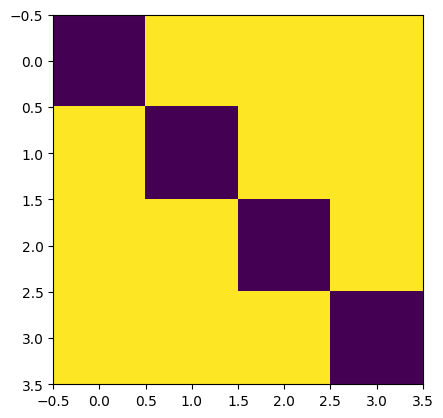

In [ ]:
import numpy as np
from utils import image_to_adj
import matplotlib.pyplot as plt


temp = np.zeros((2, 2))
adj = image_to_adj(temp)

adj = adj.cpu().detach().numpy()
adj = adj - np.eye(adj.shape[0])
plt.imshow(adj)


In [ ]:
import torch


a = torch.from_numpy(adj)
torch.where(a > 0, a, torch.tensor(1.0))

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], dtype=torch.float64)